In [1]:
from google.colab import drive
drive.mount('/content/drive/')

!pip install kornia -qqq
!pip install torchinfo -qqq
!pip install wandb -qqq

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
cd drive/MyDrive/master_thesis/final_code

/content/drive/.shortcut-targets-by-id/16udig9ZMaNcASs5Maj6kv7tg-TL3PnSE/Master Thesis/final_code


In [3]:
!nvidia-smi

Mon Nov  1 16:18:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import warnings
import time

from py_files.args import *

from py_files.functions import *

from py_files.dataset import *

from py_files.cnn_models import *
from py_files.mapping_models import *
from py_files.pigan_model import *

from py_files.load_utils import *
from py_files.data_utils import *
from py_files.plot_utils import *
from py_files.loss_utils import *
from py_files.train_utils import *
from py_files.save_utils import *

In [5]:
ARGS = init_ARGS()
        
ARGS.name = "test"
        
ARGS.cnn_setup = "golden"
ARGS.pcmra_mapping_setup = "1net"
ARGS.mapping_setup = "1net"
        
ARGS.print_models = True

ARGS.shuffle = False

ARGS.translate = False 
ARGS.crop = False
ARGS.rotate = False 
ARGS.stretch = False
ARGS.flip = False 

ARGS.batch_size = 1
        
print(vars(ARGS))

path, DEVICE = initialize_path_and_device(ARGS)

{'device': 'GPU', 'print_models': True, 'save_models': True, 'name': 'test', 'training_setup': 'segmentation', 'train_encoder_seg': True, 'pretrained': None, 'pretrained_best_dataset': 'train', 'pretrained_best_loss': 'mask', 'pretrained_models': None, 'pretrained_lr_reset': None, 'seed': 34, 'n_coords_sample': 5000, 'norm_min_max': [0, 1], 'rotate': False, 'translate': False, 'crop': False, 'stretch': False, 'flip': False, 'translate_max_pixels': 20, 'stretch_factor': 1.2, 'pcmra_epochs': 5000, 'mask_epochs': 5000, 'batch_size': 1, 'eval_every': 50, 'shuffle': False, 'min_lr': 1e-05, 'patience': 50, 'cnn_setup': 'golden', 'mapping_setup': '1net', 'dim_hidden': 256, 'siren_hidden_layers': 3, 'first_omega_0': 30.0, 'hidden_omega_0': 30.0, 'pcmra_first_omega_0': 30.0, 'pcmra_hidden_omega_0': 30.0, 'segmentation': 'binary', 'cnn_lr': 0.0001, 'mapping_lr': 0.0001, 'pcmra_mapping_lr': 0.0001, 'siren_lr': 0.0001, 'pcmra_siren_lr': 0.0001, 'cnn_wd': 0, 'siren_wd': 0, 'pcmra_siren_wd': 0, 'lam

In [6]:
root = os.path.join(os.path.abspath('..'), "Dataset", "new_original")
            
subjects = [file.split("__")[:2] for file in  sorted(os.listdir(root))]
subjects = np.array(sorted([list(subj) for subj in list(set(map(tuple, subjects)))]))

with open("py_files/dataset_split.txt") as file:
    splits = file.readlines()
    splits = [[i for i in line.rstrip().split(", ")] for line in splits]
    
train_subjects = np.array([subject for subject in subjects if subject[0] in splits[0]])[0:1]
val_subjects = np.array([subject for subject in subjects if subject[0] in splits[1]])[0:1]
test_subjects = np.array([subject for subject in subjects if subject[0] in splits[2]])[0:1]

# print(train_subjects)
# idx = list(range(subjects.shape[0]))
# split1, split2 = int(len(idx) * 0.6), int(len(idx) * 0.8)

# random.seed(ARGS.seed)
# random.shuffle(idx) # shuffles indices
# train_idx, val_idx, test_idx = idx[:split1], idx[split1:split2], idx[split2:] # incides per data subset

# train_subjects, val_subjects, test_subjects =  subjects[train_idx], subjects[val_idx], subjects[test_idx]

train_ds = SirenDataset(root, train_subjects, DEVICE)
train_dl = DataLoader(train_ds, batch_size=ARGS.batch_size, num_workers=0, shuffle=ARGS.shuffle)
print("Train subjects:", train_ds.__len__())
print("Train batch:", next(iter(train_dl))[1][:5])

val_ds =  SirenDataset(root, val_subjects, DEVICE)
val_dl = DataLoader(val_ds, batch_size=ARGS.batch_size, num_workers=0, shuffle=False)
print("Val subjects:", val_ds.__len__())
print("Val batch:", next(iter(val_dl))[1][:5])


test_ds =  SirenDataset(root, test_subjects, DEVICE)
test_dl = DataLoader(test_ds, batch_size=ARGS.batch_size, num_workers=0, shuffle=False)

print("Test subjects:", test_ds.__len__())
print("Test batch:", next(iter(test_dl))[1][:5])

Train subjects: 1
Train batch: ('1',)
Val subjects: 1
Val batch: ('10',)
Test subjects: 1
Test batch: ('13',)


('1',)
Epoch 0, train loss 0.002178
Epoch 0 took 0.11 seconds.
pcmra_loss      Train: 0.002030, 	 Eval: 0.015953
New best train loss, saving model.
('1',)
Epoch 100, train loss 0.002008
('1',)
Epoch 200, train loss 0.001972
('1',)
Epoch 300, train loss 0.002007
('1',)
Epoch 400, train loss 0.001873
('1',)
Epoch 500, train loss 0.00183
('1',)
Epoch 600, train loss 0.002025
('1',)
Epoch 700, train loss 0.001802
('1',)
Epoch 800, train loss 0.001614
('1',)
Epoch 900, train loss 0.001807
('1',)
Epoch 1000, train loss 0.00176
Epoch 1000 took 0.09 seconds.
pcmra_loss      Train: 0.001853, 	 Eval: 0.016344
New best train loss, saving model.
('1',)
Epoch 1100, train loss 0.001782
('1',)
Epoch 1200, train loss 0.001753
('1',)
Epoch 1300, train loss 0.001709
('1',)
Epoch 1400, train loss 0.001842
('1',)
Epoch 1500, train loss 0.001863
('1',)
Epoch 1600, train loss 0.001539
('1',)
Epoch 1700, train loss 0.001565
('1',)
Epoch 1800, train loss 0.001466
('1',)
Epoch 1900, train loss 0.001476
('1',)


KeyboardInterrupt: ignored

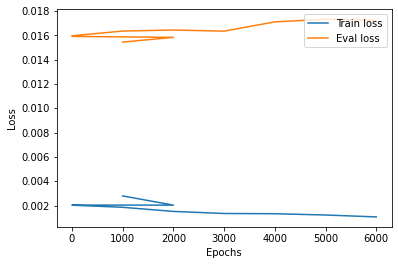

In [11]:
# ARGS.eval_every = 1000 
# ARGS.pcmra_epochs = 10000

# ARGS.min_lr = 5e-6

# ARGS.pcmra_first_omega_0 = 300

# ##### initialize models and optimizers #####
# models, optims, schedulers = initialize_models_and_optims(ARGS, DEVICE)

# mse_criterion = nn.MSELoss()

# blur_layer = initialize_blurring_layer(1.0, DEVICE)

# ##### load pretrained model #####
# load_from_saved_run(models, optims, DEVICE, ARGS)

# ##### epoch, train loss mean, train loss std, val loss mean, val loss std #####
# mask_losses, pcmra_losses, dice_losses = np.empty((0, 5)), np.empty((0, 5)), np.empty((0, 5))

for ep in range(ARGS.pcmra_epochs):
    t = time.time() 

    for model in models.values():
        model.train()

    batch = next(iter(train_dl))                
    batch = transform_batch(batch, ARGS)            

    idxs, subjs, projs, pcmra, coords_array, pcmra_array, mask_array, surface_array, norm_array = \
        get_siren_batch(batch, blur_layer, ARGS.n_coords_sample, ARGS)

    losses = [] 
     
    model_keys = ["cnn", "pcmra_mapping", "pcmra_siren"]

    # Forward pass
    latent_rep = models["cnn"](pcmra) # get latent representation 
    gamma, beta = models["pcmra_mapping"](latent_rep)
    # gamma = torch.ones(1, 256).cuda()
    # beta = torch.zeros(1, 256).cuda()
    out, _ = models["pcmra_siren"](coords_array, gamma, beta)            

    # Backward pass
    loss = mse_criterion(out, pcmra_array)  
    loss.backward()
    losses.append(loss.item())
    
    for key in model_keys: 
        optims[key].step()
        optims[key].zero_grad()
    
    loss, _ = round(np.mean(losses), 6), round(np.std(losses), 6)

    for key in model_keys: 
        schedulers[key].step(loss)
    
    if ep % 100 == 0: 
        print(subjs)
        print(f"Epoch {ep}, train loss {loss.round(6)}")

    if ep % ARGS.eval_every == 0: 

        print(f"Epoch {ep} took {round(time.time() - t, 2)} seconds.")

        pcmra_losses, _ = validation_epoch(ep, train_dl, val_dl, models, optims, blur_layer, pcmra_losses, None, "pcmra", ARGS) 
        
        # # check if training improved last 200 epochs
        # if (pcmra_losses.shape[0] - np.argmin(pcmra_losses[:, 1])) > (200 / ARGS.eval_every) and \
        # optims["cnn"].param_groups[0]['lr'] == ARGS.min_lr:
        #     break

In [12]:
batch = next(iter(train_dl))
                
batch = transform_batch(batch, ARGS)  

idxs, subjs, projs, pcmra, coords_array, pcmra_array, mask_array, surface_array, norm_array = \
    get_siren_batch(batch, blur_layer, -1, ARGS)

print(subjs)

pcmras = masks = surfaces = norms_x = norms_y = norms_z = mask_outs = pcmra_outs = torch.Tensor([])

coords_array = get_coords(24, 128, 128).to(DEVICE)
coords_array = coords_array.unsqueeze(0).repeat(pcmra_array.shape[0], 1, 1)


pcmra_out, _ = models["pcmra_siren"](coords_array, gamma, beta)            

for subj, s_pcmra_array, s_mask_array, s_surface_array, s_norm_array, s_pcmra_out in zip(subjs, pcmra_array, mask_array, surface_array, norm_array, pcmra_out):

    pcmras = torch.cat((pcmras, s_pcmra_array.cpu().view(24, 128, 128).detach().permute(1, 2, 0)), 2)
    pcmra_outs = torch.cat((pcmra_outs, s_pcmra_out.cpu().view(24, 128, 128).detach().permute(1, 2, 0)), 2)


('1',)


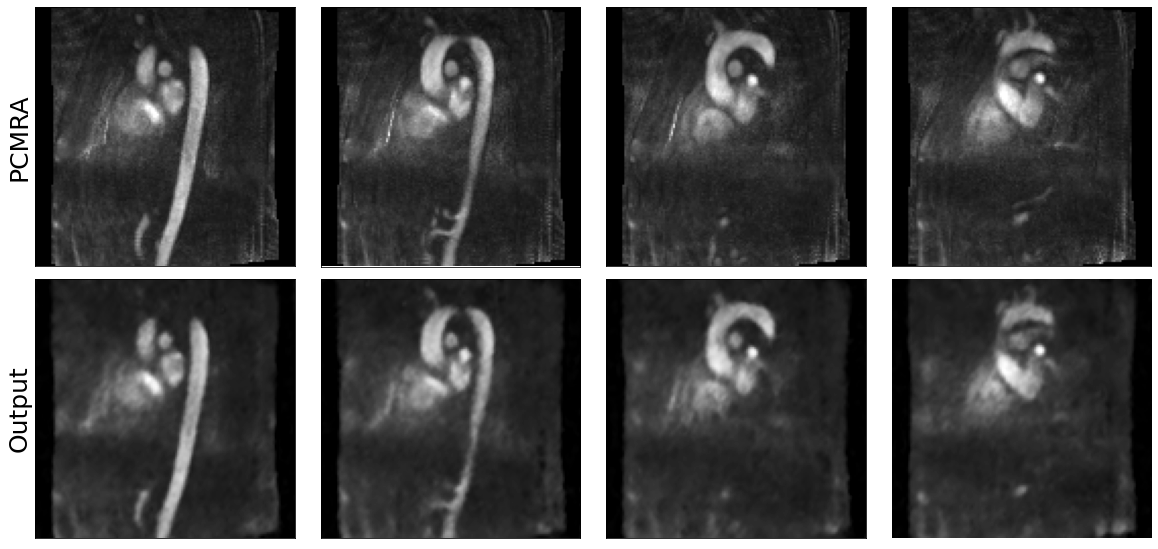

In [13]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for row in axs:
    for ax in row:
        ax.set_xticks([])
        ax.set_yticks([])

fig.subplots_adjust(wspace=0.1, hspace=0)

plt.axis('off')

i = 9
axs[0, 0].imshow(pcmras[:,:,i], cmap="gist_gray", vmin=0, vmax=1)
axs[1, 0].imshow(pcmra_outs[:,:,i], cmap="gist_gray", vmin=0, vmax=1)

axs[0, 0].set_ylabel("PCMRA", fontsize=25)
axs[1, 0].set_ylabel("Output", fontsize=25)

i = 12
axs[0, 1].imshow(pcmras[:,:,i], cmap="gist_gray", vmin=0, vmax=1)
axs[1, 1].imshow(pcmra_outs[:,:,i], cmap="gist_gray", vmin=0, vmax=1)

i = 15
axs[0, 2].imshow(pcmras[:,:,i], cmap="gist_gray", vmin=0, vmax=1)
axs[1, 2].imshow(pcmra_outs[:,:,i], cmap="gist_gray", vmin=0, vmax=1)

i = 18
axs[0, 3].imshow(pcmras[:,:,i], cmap="gist_gray", vmin=0, vmax=1)
axs[1, 3].imshow(pcmra_outs[:,:,i], cmap="gist_gray", vmin=0, vmax=1)
plt.show()
